In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Using text and neural network features

Welcome to the **Intermediate Colab** for **TensorFlow Decision Forests**
(**TF-DF**).
In this colab, you will learn about some more advanced capabilities of
**TF-DF**, including how to deal with natural language features.

This colab assumes you are familiar with the concepts presented the
[Beginner colab](https://www.tensorflow.org/decision_forests/tutorials/beginner_colab),
notably about the installation about TF-DF.

In this colab, you will:

1. Train a Random Forest that consumes text features natively as categorical sets.

1. Train a Random Forest that consumes text features using a [TensorFlow Hub](https://www.tensorflow.org/hub) module. In this setting (transfer learning), the module is already pre-trained on a large text corpus.

1. Train a Gradient Boosted Decision Trees (GBDT) and a Neural Network together. The GBDT will consume the output of the Neural Network.

## Setup

In [1]:
# Install TensorFlow Dececision Forests
# !pip install tensorflow_decision_forests

Install [Wurlitzer](https://pypi.org/project/wurlitzer/). It can be used to show
the detailed training logs. This is only needed in colabs.

In [2]:
# !pip install wurlitzer

Import the necessary libraries.

In [3]:
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math

try:
  from wurlitzer import sys_pipes
except:
  from colabtools.googlelog import CaptureLog as sys_pipes

from IPython.core.magic import register_line_magic
from IPython.display import Javascript

2022-03-13 00:41:29.278785: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-13 00:41:29.278831: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Use raw text as features

TF-DF can consume [categorical-set](https://arxiv.org/pdf/2009.09991.pdf)
features natively. Categorical-sets represent text features as bags of words
(or n-grams).

For example: `"The little blue dog" ` → `{"the", "little", "blue", "dog"}`

In this example, you'll will train a Random Forest on the
[Stanford Sentiment Treebank](https://nlp.stanford.edu/sentiment/index.html)
(SST) dataset. The objective of this dataset is to classify sentences as
carrying a *positive* or *negative* sentiment. You'll will use the binary
classification version of the dataset curated in
[TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/glue#gluesst2).

**Note:** Categorical-set features can be expensive to train. In this colab, we
will train a small Random Forest with 20 trees.

In [5]:
# Install the nighly TensorFlow Datasets package
# TODO: Remove when the release package is fixed.
# !pip install tfds-nightly -U --quiet

In [6]:
# Load the dataset
import tensorflow_datasets as tfds
all_ds = tfds.load("glue/sst2")

# Display the first 3 examples of the test fold.
for example in all_ds["test"].take(3):
  print({attr_name: attr_tensor.numpy() for attr_name, attr_tensor in example.items()})

{'idx': 163, 'label': -1, 'sentence': b'not even the hanson brothers can save it'}
{'idx': 131, 'label': -1, 'sentence': b'strong setup and ambitious goals fade as the film descends into unsophisticated scare tactics and b-film thuggery .'}
{'idx': 1579, 'label': -1, 'sentence': b'too timid to bring a sense of closure to an ugly chapter of the twentieth century .'}


2022-03-13 00:43:44.490876: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


The dataset is modified as follows:

1. The raw labels are integers in `{-1, 1}`, but the learning algorithm expects positive integer labels e.g. `{0, 1}`. Therefore, the labels are transformed as follows: `new_labels = (original_labels + 1) / 2`.
1. A batch-size of 64 is applied to make reading the dataset more efficient.
1. The `sentence` attribute needs to be tokenized, i.e. `"hello world" -> ["hello", "world"]`.


**Note:** This example doesn't use the `test` split of the dataset as it does
not have labels. If `test` split had labels, you could concatenate the
`validation` fold into the `train` one (e.g. `all_ds["train"].concatenate(all_ds["validation"])`).

**Details:** Some decision forest learning algorithms do not need a validation
dataset (e.g. Random Forests) while others do
(e.g. Gradient Boosted Trees in some cases). Since each learning algorithm under
TF-DF can use validation data differently, TF-DF handles train/validation splits
internally. As a result, when you have a training and validation sets, they can
always be concatenated as input to the learning algorithm.

In [7]:
def prepare_dataset(example):
  label = (example["label"] + 1) // 2
  return {"sentence" : tf.strings.split(example["sentence"])}, label

train_ds = all_ds["train"].batch(64).map(prepare_dataset)
test_ds = all_ds["validation"].batch(64).map(prepare_dataset)

Finaly, train and evaluate the model as usual. TF-DF  automatically detects
multi-valued categorical features as categorical-set.


In [8]:
# %set_cell_height 300

# Specify the model.
model_1 = tfdf.keras.RandomForestModel(num_trees=30)

# Optionally, add evaluation metrics.
model_1.compile(metrics=["accuracy"])

# Train the model.
with sys_pipes():
  model_1.fit(x=train_ds)

Use /tmp/tmp8l4grh9w as temporary training directory
Starting reading the dataset
1043/1053 [============================>.] - ETA: 0s
Dataset read in 0:00:07.610874
Training model
Model trained in 0:04:25.675454
Compiling model


[INFO kernel.cc:1153] Loading model from path
[INFO abstract_model.cc:1063] Engine "RandomForestGeneric" built
[INFO kernel.cc:1001] Use fast generic engine


1053/1053 [==============================] - 274s 257ms/step
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In the previous logs, note that `sentence` is a `CATEGORICAL_SET` feature.

The model is evaluated as usual:

In [9]:
evaluation = model_1.evaluate(test_ds)

print(f"BinaryCrossentropyloss: {evaluation[0]}")
print(f"Accuracy: {evaluation[1]}")

14/14 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 0.7638
BinaryCrossentropyloss: 0.0
Accuracy: 0.7637614607810974


The training logs looks are follow:

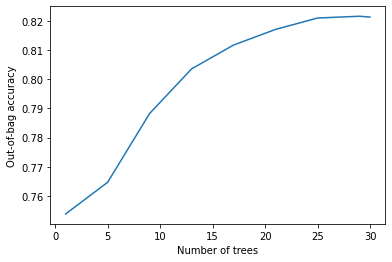

In [10]:
import matplotlib.pyplot as plt

logs = model_1.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Out-of-bag accuracy")
pass

More trees would probably be beneficial (I am sure of it because I tried :p).

## Use a pretrained text embedding

The previous example trained a Random Forest using raw text features. This
example will use a pre-trained TF-Hub embedding to convert text features into a
dense embedding, and then train a Random Forest on top of it. In this situation,
the Random Forest will only "see" the numerical output of the embedding
(i.e. it will not see the raw text). 

In this experiment,  will use the
[Universal-Sentence-Encoder](https://tfhub.dev/google/universal-sentence-encoder/4).
Different pre-trained embeddings might be suited for different types of text
(e.g. different language, different task) but also for other type of structured
features (e.g. images).

**Note:** This embedding is large (1GB) and therefore the final model will be
slow to run (compared to classical decision tree inference).

The embedding module can be applied in one of two places:

1. During the dataset preparation.
2. In the pre-processing stage of the model.

The second option is often preferable: Packaging the embedding in the model
makes the model easier to use (and harder to misuse).

First install TF-Hub:

In [12]:
# !pip install --upgrade tensorflow-hub

Unlike before, you don't need to tokenize the text.

In [11]:
def prepare_dataset(example):
  label = (example["label"] + 1) // 2
  return {"sentence" : example["sentence"]}, label

train_ds = all_ds["train"].batch(64).map(prepare_dataset)
test_ds = all_ds["validation"].batch(64).map(prepare_dataset)


In [12]:
# %set_cell_height 300

import tensorflow_hub as hub
# NNLM (https://tfhub.dev/google/nnlm-en-dim128/2) is also a good choice.
hub_url = "http://tfhub.dev/google/universal-sentence-encoder/4"
embedding = hub.KerasLayer(hub_url)

sentence = tf.keras.layers.Input(shape=(), name="sentence", dtype=tf.string)
embedded_sentence = embedding(sentence)

raw_inputs = {"sentence": sentence}
processed_inputs = {"embedded_sentence": embedded_sentence}
preprocessor = tf.keras.Model(inputs=raw_inputs, outputs=processed_inputs)

model_2 = tfdf.keras.RandomForestModel(
    preprocessing=preprocessor,
    num_trees=100)
model_2.compile(metrics=["accuracy"])

with sys_pipes():
  model_2.fit(x=train_ds)

Use /tmp/tmptvim_5pn as temporary training directory
Starting reading the dataset
1050/1053 [============================>.] - ETA: 0s
Dataset read in 0:00:17.926571
Training model
Model trained in 0:00:45.377435
Compiling model


[INFO kernel.cc:1153] Loading model from path
[INFO abstract_model.cc:1063] Engine "RandomForestOptPred" built
[INFO kernel.cc:1001] Use fast generic engine


1053/1053 [==============================] - 65s 56ms/step


In [13]:
evaluation = model_2.evaluate(test_ds)

print(f"BinaryCrossentropyloss: {evaluation[0]}")
print(f"Accuracy: {evaluation[1]}")

14/14 [==============================] - 2s 13ms/step - loss: 0.0000e+00 - accuracy: 0.7856
BinaryCrossentropyloss: 0.0
Accuracy: 0.7855504751205444


Note that categorical sets represent text differently from a dense embedding,
so it may be useful to use both strategies jointly.

## Train a decision tree and neural network together

The previous example used a pre-trained Neural Network (NN) to process the text
features before passing them to the Random Forest. This example will train both
the Neural Network and the Random Forest from scratch.

TF-DF's Decision Forests do not back-propagate gradients
([although this is the subject of ongoing research](https://arxiv.org/abs/2007.14761)).
Therefore, the training happens in two stages:

1. Train the neural-network as a standard classification task:

    ```
    example → [Normalize] → [Neural Network*] → [classification head] → prediction
    *: Training.
    ```

2. Replace the Neural Network's head (the last layer and the soft-max) with a Random Forest. Train the Random Forest as usual:

    ```
    example → [Normalize] → [Neural Network] → [Random Forest*] → prediction
    *: Training.
    ```



### Prepare the dataset

This example uses the
[Palmer's Penguins](https://allisonhorst.github.io/palmerpenguins/articles/intro.html)
dataset. See the
[Beginner colab](https://www.tensorflow.org/decision_forests/tutorials/beginner_colab)
for details.

First, download the raw data:

In [16]:
# !wget -q https://storage.googleapis.com/download.tensorflow.org/data/palmer_penguins/penguins.csv -O /tmp/penguins.csv
!curl -L --output /tmp/penguins.csv https://storage.googleapis.com/download.tensorflow.org/data/palmer_penguins/penguins.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 15241  100 15241    0     0   175k      0 --:--:-- --:--:-- --:--:--  175k


Load a dataset into a Pandas Dataframe.

In [17]:
dataset_df = pd.read_csv("/tmp/penguins.csv")

# Display the first 3 examples.
dataset_df.head(3)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007



Prepare the dataset for training.

In [18]:
label = "species"

# Replaces numerical NaN (representing missing values in Pandas Dataframe) with 0s.
# ...Neural Nets don't work well with numerical NaNs.
for col in dataset_df.columns:
  if dataset_df[col].dtype not in [str, object]:
    dataset_df[col] = dataset_df[col].fillna(0)

In [19]:
# Split the dataset into a training and testing dataset.

def split_dataset(dataset, test_ratio=0.30):
  """Splits a panda dataframe in two."""
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, test_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

# Convert the datasets into tensorflow datasets
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=label)

241 examples in training, 103 examples for testing.


/usr/local/lib/python3.8/dist-packages/tensorflow_decision_forests/keras/core.py:2036: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features_dataframe = dataframe.drop(label, 1)
/usr/local/lib/python3.8/dist-packages/tensorflow_decision_forests/keras/core.py:2036: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features_dataframe = dataframe.drop(label, 1)


### Build the models

Next create the neural network model using
[Keras' functional style](https://www.tensorflow.org/guide/keras/functional). 

To keep the example simple this model only uses two inputs.

In [22]:
input_1 = tf.keras.Input(shape=(1,), name="bill_length_mm", dtype="float")
input_2 = tf.keras.Input(shape=(1,), name="island", dtype="string")

nn_raw_inputs = [input_1, input_2]

Use
[preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers)
to convert the raw inputs to inputs apropriate for the neural netrwork. 

In [23]:
# Normalization.
Normalization = tf.keras.layers.Normalization
CategoryEncoding = tf.keras.layers.CategoryEncoding
StringLookup = tf.keras.layers.StringLookup

values = train_ds_pd["bill_length_mm"].values[:, tf.newaxis]
input_1_normalizer = Normalization()
input_1_normalizer.adapt(values)

values = train_ds_pd["island"].values
input_2_indexer = StringLookup(max_tokens=32)
input_2_indexer.adapt(values)

input_2_onehot = CategoryEncoding(output_mode="binary", max_tokens=32)

normalized_input_1 = input_1_normalizer(input_1)
normalized_input_2 = input_2_onehot(input_2_indexer(input_2))

nn_processed_inputs = [normalized_input_1, normalized_input_2]

Build the body of the neural network:

In [25]:
y = tf.keras.layers.Concatenate()(nn_processed_inputs)
y = tf.keras.layers.Dense(16, activation=tf.nn.relu6)(y)
last_layer = tf.keras.layers.Dense(8, activation=tf.nn.relu, name="last")(y)

# "3" for the three label classes. If it were a binary classification, the
# output dim would be 1.
classification_output = tf.keras.layers.Dense(3)(y)

nn_model = tf.keras.models.Model(nn_raw_inputs, classification_output)

This `nn_model` directly produces classification logits. 

Next create a decision forest model. This will operate on the high level
features that the neural network extracts in the last layer before that classification head.

In [26]:
# To reduce the risk of mistakes, group both the decision forest and the
# neural network in a single keras model.
nn_without_head = tf.keras.models.Model(inputs=nn_model.inputs, outputs=last_layer)
df_and_nn_model = tfdf.keras.RandomForestModel(preprocessing=nn_without_head)

Use /tmp/tmpqne_zltj as temporary training directory


### Train and evaluate the models

The model will be trained in two stages. First train the neural network with its
own classification head:

In [27]:
# %set_cell_height 300

nn_model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=["accuracy"])

nn_model.fit(x=train_ds, validation_data=test_ds, epochs=10)
nn_model.summary()

Epoch 1/10


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex', 'year'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 1s 1s/step - loss: 0.9867 - accuracy: 0.5311 - val_loss: 1.0137 - val_accuracy: 0.5049
Epoch 2/10
1/1 [==============================] - 0s 47ms/step - loss: 0.9828 - accuracy: 0.5560 - val_loss: 1.0104 - val_accuracy: 0.5146
Epoch 3/10
1/1 [==============================] - 0s 27ms/step - loss: 0.9789 - accuracy: 0.5726 - val_loss: 1.0070 - val_accuracy: 0.5340
Epoch 4/10
1/1 [==============================] - 0s 35ms/step - loss: 0.9751 - accuracy: 0.5768 - val_loss: 1.0037 - val_accuracy: 0.5340
Epoch 5/10
1/1 [==============================] - 0s 32ms/step - loss: 0.9712 - accuracy: 0.5934 - val_loss: 1.0004 - val_accuracy: 0.5340
Epoch 6/10
1/1 [==============================] - 0s 30ms/step - loss: 0.9674 - accuracy: 0.6058 - val_loss: 0.9971 - val_accuracy: 0.5340
Epoch 7/10
1/1 [==============================] - 0s 40ms/step - loss: 0.9636 - accuracy: 0.6100 - val_loss: 0.9939 - val_accuracy: 0.5437
Epoch 8/10
1/1 [========================

The neural network layers are shared between the two models. So now that the
neural network is trained the decision forest model will be fit to the trained
output of the neural network layers:

In [28]:
# %set_cell_height 300

df_and_nn_model.compile(metrics=["accuracy"])
with sys_pipes():
  df_and_nn_model.fit(x=train_ds)

Starting reading the dataset
1/1 [==============================] - ETA: 0s
Dataset read in 0:00:00.279747
Training model
Model trained in 0:00:00.064304
Compiling model


[INFO kernel.cc:1153] Loading model from path
[INFO abstract_model.cc:1063] Engine "RandomForestGeneric" built
[INFO kernel.cc:1001] Use fast generic engine


1/1 [==============================] - 0s 368ms/step


Now evaluate the composed model:

In [29]:
print("Evaluation:", df_and_nn_model.evaluate(test_ds))

1/1 [==============================] - 0s 161ms/step - loss: 0.0000e+00 - accuracy: 0.9320
Evaluation: [0.0, 0.9320388436317444]


Compare it to the Neural Network alone:

In [30]:
print("Evaluation :", nn_model.evaluate(test_ds))

1/1 [==============================] - 0s 15ms/step - loss: 0.9842 - accuracy: 0.6117
Evaluation : [0.984201967716217, 0.6116504669189453]
